In [3]:
from connection import pre_process_sc
from connection import build_one_area
from connection import coordination
from connection import poisson_stimuli

import brian2.numpy_ as np
from brian2.only import *

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import time
import os
import datetime
import sys
import pickle

lattice = coordination.makelattice(64, 64, [0,0])


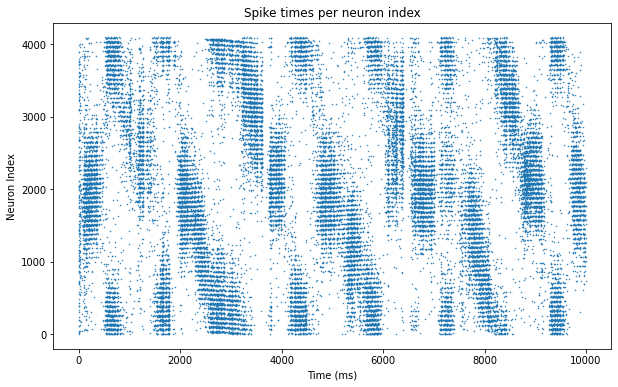

In [86]:
with open('two_stimGaussian_w66.pickle', 'rb') as handle:
    data = pickle.load(handle)
spike_times = data['a1']['ge']['t']
spike_index = data['a1']['ge']['i']

plt.figure(figsize=(10,6))
plt.plot(data['a1']['ge']['t'],data['a1']['ge']['i'],'.',markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Spike times per neuron index')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))

bin_width = 5 #ms
totaltime = 10000 #ms
bins = np.arange(0,totaltime,bin_width)
hist, bin_edges = np.histogram(data['a1']['ge']['t'], bins =bins)
bin_centers = bin_edges + bin_width/2
num_neurons = 4096

frequency = hist*1000/bin_width/num_neurons
plt.bar(bin_centers[:-1],hist,width=bin_width)

plt.xlabel('Time (ms)')
plt.ylabel('# neurons firing')
plt.title('Neuron spike count / time')
plt.show()

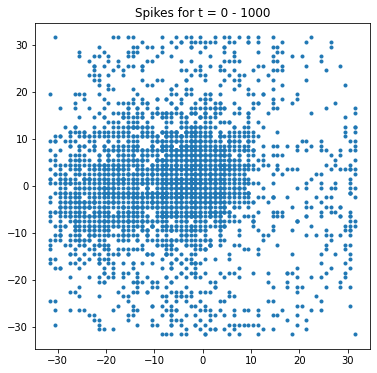

In [11]:
%matplotlib inline

start = 000
end = 1000
lfilt = spike_times >= start
rfilt = spike_times <= end
spike_times_filt = spike_times[lfilt & rfilt]
spike_index_filt = spike_index[lfilt & rfilt]

plt.figure(figsize=(6,6))
plt.plot(lattice[spike_index_filt][:,0],lattice[spike_index_filt][:,1],'.')
plt.title("Spikes for t = " + str(start) + " - " + str(end))
plt.show()


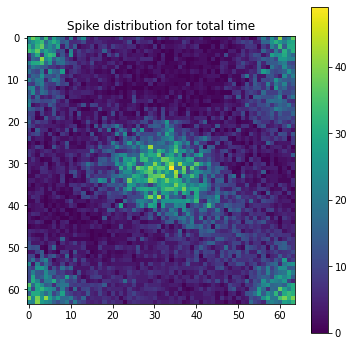

In [87]:
%matplotlib inline
fig=plt.figure(figsize=(6,6))
# ax=plt.axes(projection='3d')
numbins = 64
hist, xedges, yedges = np.histogram2d(lattice[spike_index][:,0],
                lattice[spike_index][:,1],bins=numbins)

plt.imshow(hist.T)
plt.colorbar()
plt.title("Spike distribution for total time")
plt.show()

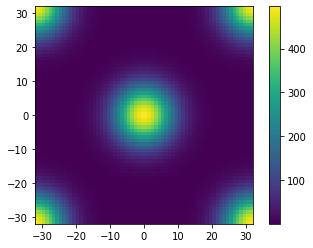

In [88]:
from connection import poisson_stimuli
rate = poisson_stimuli.input_spkrate(maxrate=[500,500], sig=[6,6], position=[[0,0],[-32,-32]])
rate = rate.reshape(64,64)
#%%
plt.figure()
plt.imshow(rate, extent=[-32,32,-32,32])
plt.colorbar()
plt.show()


In [ ]:
adapt = poisson_stimuli.input_adaptation([0,8], sig=[6,6], position=[[0,0],[-32,32]])
adapt = adapt.reshape(64,64)
#%%
plt.figure()
plt.imshow(adapt, extent=[-32,32,-32,32])
plt.colorbar()
plt.show()

## Centre of mass animation

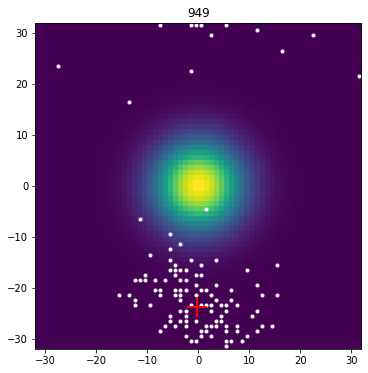

In [64]:
%matplotlib inline
fig,ax1 = plt.subplots(figsize=(6,6))
pi = np.pi
L = 64/2
binwidth = 1 #ms
totaltime = 1000 #ms
timesteps = np.arange(0,totaltime,binwidth)
t_window = 50
COM_history = {'x':[],'y':[]}
def animate_spikes(t):
    start_time = timesteps[t]
    stop_time = timesteps[t+t_window]
    index_spikes_to_plot = (spike_times>=start_time) & (spike_times<stop_time)
    spike = spike_index[index_spikes_to_plot]
    ax1.clear()
    ax1.set_xlim((-32,32))
    ax1.set_ylim((-32,32))
    plt.imshow(rate, extent=[-32,32,-32,32])
    plt.plot(lattice[spike][:,0],lattice[spike][:,1],'.w',ms=6,linewidth=0.5)
    ax1.set_title(t)
    values, counts = np.unique(spike, return_counts = True)
    x = lattice[values][:,0]
    y = lattice[values][:,1]
    x_COM = np.angle(sum(counts*exp(pi*1j*x/L)))*L/pi
    y_COM = np.angle(sum(counts*exp(pi*1j*y/L)))*L/pi
    plt.plot(x_COM,y_COM,'r+',mew=2,ms=20)
    COM_history['x'].append(x_COM)
    COM_history['y'].append(y_COM)
anim = animation.FuncAnimation(fig,animate_spikes,frames=range(len(timesteps)-t_window),interval=10);
# writervideo = animation.FFMpegWriter(fps=30) 
anim.save('COM_moving_stim.mp4',writer='ffmpeg',fps=30)
# from IPython.display import HTML
# HTML(anim.to_jshtml())

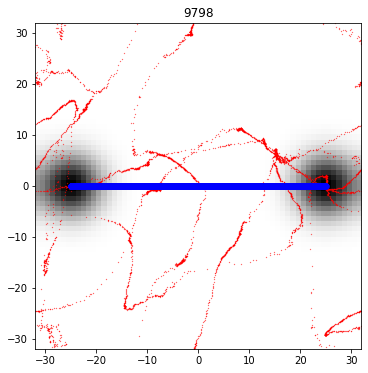

In [83]:
# import matplotlib
# matplotlib.use("Agg")
# from matplotlib.animation import FFMpegWriter

fig,ax1 = plt.subplots(figsize=(6,6))
plt.imshow(rate, extent=[-32,32,-32,32],cmap='gray_r')

pi = np.pi
L = 64/2
binwidth = 2 #ms
totaltime = 10000 #ms
timesteps = np.arange(0,totaltime,binwidth)

t_window = 100

xdata, ydata = [], []
xdata_s, ydata_s = [], []
ln_com, = ax1.plot([0], [0],'r.',ms=0.5)
ln_stim, = ax1.plot([0], [0],'bo',ms=5)
def animate_spikes(t):
    # ax1.clear()
    start_time = timesteps[t]
    stop_time = timesteps[t+t_window]
    index_spikes_to_plot = (spike_times>=start_time) & (spike_times<stop_time)
    spike = spike_index[index_spikes_to_plot]
    values, counts = np.unique(spike, return_counts = True)
    x = lattice[values][:,0]
    y = lattice[values][:,1]
    x_COM = np.angle(sum(counts*exp(pi*1j*x/L)))*L/pi
    y_COM = np.angle(sum(counts*exp(pi*1j*y/L)))*L/pi
    xdata.append(x_COM)
    ydata.append(y_COM)
    xdata_s.append(-25 + t*50/(len(timesteps)-t_window))
    ydata_s.append(0)

    ln_com.set_data(xdata, ydata)
    ln_stim.set_data(xdata_s, ydata_s)

    # ax1.plot(x_COM,y_COM,'r+',mew=2,ms=20)
    plt.title(timesteps[t])
    plt.xlim((-32,32))
    plt.ylim((-32,32))
    return ln_com, ln_stim,

anim = animation.FuncAnimation(fig,animate_spikes,frames=range(len(timesteps)-t_window),interval=1,blit=True);
# writervideo = animation.FFMpegWriter(fps=30) 
anim.save('movingstim_COMtraj2.mp4',writer='ffmpeg',fps=60)
# from IPython.display import HTML
# HTML(anim.to_jshtml())

In [44]:
len(timesteps)

200

## Centre of mass trajectory

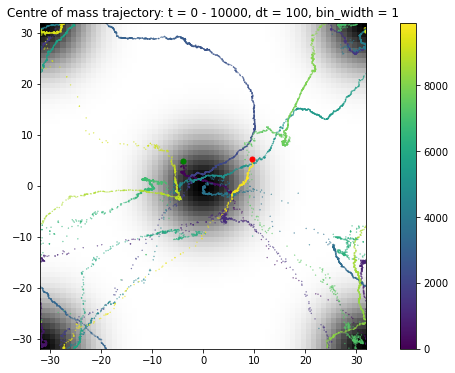

In [97]:
pi = np.pi
L = 64/2

binwidth = 1 #ms
start_time = 0 #ms
end_time = 10000
timesteps = np.arange(start_time,end_time,binwidth)
t_window = 100

COM_history = {'x':[],'y':[]}
for t in np.arange(0,len(timesteps)-t_window):
    start_time_w = timesteps[t]
    stop_time_w = timesteps[t+t_window]
    index_spikes_to_plot = (spike_times>=start_time_w) & (spike_times<stop_time_w)
    spike = spike_index[index_spikes_to_plot]

    values, counts = np.unique(spike, return_counts = True)
    x = lattice[values][:,0]
    y = lattice[values][:,1]

    x_COM = np.angle(sum(counts*exp(pi*1j*x/L)))*L/pi
    y_COM = np.angle(sum(counts*exp(pi*1j*y/L)))*L/pi

    COM_history['x'].append(x_COM)
    COM_history['y'].append(y_COM)

abs_diff_x = np.abs(np.diff(COM_history['x']))
mask_x = np.hstack([ abs_diff_x > abs_diff_x.mean()+3*abs_diff_x.std(), [False]])
masked_x = np.ma.MaskedArray(COM_history['x'], mask_x)

abs_diff_y = np.abs(np.diff(COM_history['y']))
mask_y = np.hstack([ abs_diff_y > abs_diff_y.mean()+3*abs_diff_y.std(), [False]])
masked_y = np.ma.MaskedArray(COM_history['y'], mask_y)

# PLotting
fig = plt.figure(figsize=(12,6))

plt.imshow(rate, extent=[-32,32,-32,32],cmap='gray_r')
# ax1.plot(masked_x,masked_y,'.-',markersize=2,linewidth=0.6)
plt.plot(COM_history['x'][0],COM_history['y'][0],'og',markersize=5,linewidth=0.1)
plt.plot(COM_history['x'][-1],COM_history['y'][-1],'or',markersize=5,linewidth=0.1)
plt.scatter(COM_history['x'],COM_history['y'],c = np.arange(0,len(timesteps)-t_window), s = 0.1, \
    cmap = 'viridis')
plt.colorbar()
plt.xlim((-32,32))
plt.ylim((-32,32))
plt.title("Centre of mass trajectory: t = " + str(start_time) + " - " + str(end_time) + 
    ", dt = " + str(t_window) + ", bin_width = " + str(binwidth))
plt.show()

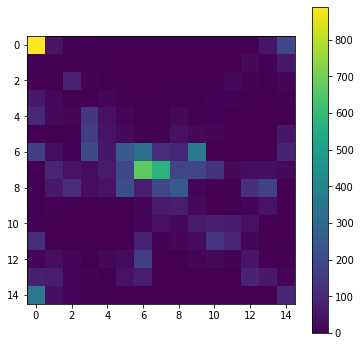

In [51]:
fig=plt.figure(figsize=(6,6))
numbins = 15
hist, xedges, yedges = np.histogram2d(COM_history['x'],
                COM_history['y'],bins=numbins)

plt.imshow(hist.T)
plt.colorbar()
plt.show()

## Mean exit time computation/visualisation?
Need to change metric to be within a few stds of the stimulus, so wandering empty space is considered wandering empty space

In [100]:
# Just find the width of each Gaussian using STD, and figure position out later
# Method is NOT generalisable: stim 1 has to be centre, stim 2 has to be corner
rates1 = poisson_stimuli.input_spkrate(maxrate = [500], sig=[6], position=[[0, 0]]) 
rates2 = poisson_stimuli.input_spkrate(maxrate = [500], sig=[6], position=[[-32, -32]])

gaussian1 = np.argwhere(rates1>2*6).squeeze()
radius1 = 0.5*(max(lattice[gaussian1][:,0]) - min(lattice[gaussian1][:,0]))
gaussian2 = np.argwhere(rates2>2*6).squeeze()
radius2 = (max(lattice[gaussian2][:,0][lattice[gaussian2][:,0]<0]) - min(lattice[gaussian2][:,0]))

stim_loc1 = np.array([0,0])
stim_loc2 = np.array([[-32,-32],[32,-32],[-32,32],[32,32]])

x = COM_history["x"]
y = COM_history["y"]

dist1 = ((x-stim_loc1[0])**2 + (y-stim_loc1[1])**2)**0.5
dist2 = [((x-stim_loc[0])**2 + (y-stim_loc[1])**2)**0.5 for stim_loc in stim_loc2]

a1 = (dist1<radius1)
a2 = (dist2<radius2)
a2 = a2.any(axis = 0)  # close to any corner == close to stim2
print(sum(a1),sum(a2),sum(a2)/sum(a1),len(x))
if a1[0]:
    durations1 = np.diff(np.insert(np.argwhere(np.diff(a1)).squeeze(),0,0))
    durations1 = [durations1[i] for i in range(len(durations1)) if i%2 == 0]
    durations2 = np.diff(np.argwhere(np.diff(a2)).squeeze())
    durations2 = [durations2[i] for i in range(len(durations2)) if i%2 == 0]
else:
    durations2 = np.diff(np.insert(np.argwhere(np.diff(a2)).squeeze(),0,0))
    durations2 = [durations2[i] for i in range(len(durations2)) if i%2 == 0]
    durations1 = np.diff(np.argwhere(np.diff(a1)).squeeze())
    durations1 = [durations1[i] for i in range(len(durations1)) if i%2 == 0]
print(durations1,np.mean(durations1))
print(durations2,np.mean(durations2))
print(np.mean(durations2)/np.mean(durations1))

3723 3417 0.9178082191780822 9900
[422, 366, 470, 432, 553, 164, 1, 498, 1, 80, 1, 435, 1] 263.38461538461536
[407, 430, 343, 502, 464, 317, 28, 528, 397, 1] 341.7
1.2973422897196263


## MSD - time lag on loglog
Want this to be linear, to show MSD is a power function of time lag with some diffusion coefficient > 1 for superdiffusive process (1 stimulus). 

1
2
3
4
6
9
13
18
26
38
55
78
113
162
234
336
483
695
1000


Text(0, 0.5, 'MSD')

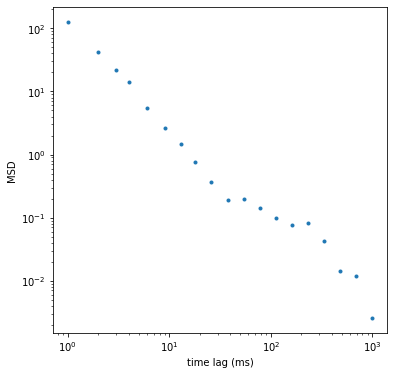

In [42]:
%matplotlib inline

fig,ax1 = plt.subplots(figsize=(6,6))

pi = np.pi
L = 64/2

binwidth = 2 #ms
start_time = 0 #ms
end_time = 10000
timesteps = np.arange(start_time,end_time,binwidth)
t_window = 15
COM_history_window = {}
for t_window in np.unique(np.round(np.logspace(0,3,20))).astype(int):
    COM_history = {'x':[],'y':[]}
    for t in np.arange(0,len(timesteps)-t_window):
        start_time = timesteps[t]
        stop_time = timesteps[t+t_window]
        index_spikes_to_plot = (spike_times>=start_time) & (spike_times<stop_time)

        spike = spike_index[index_spikes_to_plot]

        values, counts = np.unique(spike, return_counts = True)
        x = lattice[values][:,0]
        y = lattice[values][:,1]

        x_COM = np.angle(sum(counts*exp(pi*1j*x/L)))*L/pi
        y_COM = np.angle(sum(counts*exp(pi*1j*y/L)))*L/pi

        COM_history['x'].append(x_COM)
        COM_history['y'].append(y_COM)

    abs_diff_x = np.abs(np.diff(COM_history['x']))
    mask_x = np.hstack([ abs_diff_x > abs_diff_x.mean()+3*abs_diff_x.std(), [False]])
    masked_x = np.ma.MaskedArray(COM_history['x'], mask_x)

    abs_diff_y = np.abs(np.diff(COM_history['y']))
    mask_y = np.hstack([ abs_diff_y > abs_diff_y.mean()+3*abs_diff_y.std(), [False]])
    masked_y = np.ma.MaskedArray(COM_history['y'], mask_y)

    COM_history['x'] = masked_x
    COM_history['y'] = masked_y
    COM_history_window[t_window] = COM_history
    print(t_window)

# MSD-timestep (this should only be for 1 stimuli, not 2)
jump_MSD = []
t_windows = []
for item in COM_history_window:
    x_COM = COM_history_window[item]["x"]
    y_COM = COM_history_window[item]["y"]
    MSD = np.mean(np.diff((x_COM**2+y_COM**2)**0.5)**2)
    jump_MSD.append(MSD) 
    t_windows.append(item)

plt.loglog(t_windows,jump_MSD,'.')
plt.xlabel("time lag (ms)")
plt.ylabel("MSD")

## Increment historgram
Plotting the distribution of COM increment sizes, want this to be heavy tailed with a linear tail in log-log space.

-2.047252549871744 2.1483673294474785
Reduced chi-squared value: 1.1247257064570597


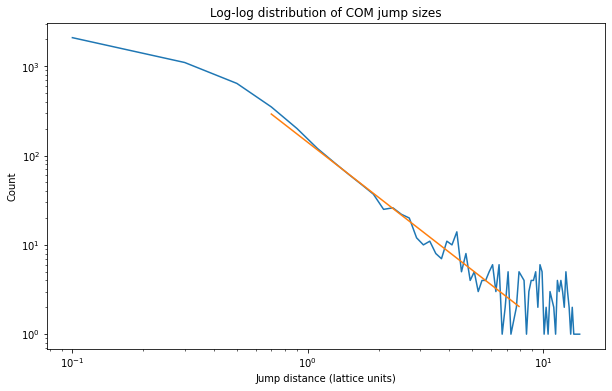

In [96]:
# histogram of jump sizes PLEASE TAKE INTO ACCOUNT PBC

jump_MSD = np.diff((masked_x**2+masked_y**2)**0.5)
fig,ax = plt.subplots(figsize=(10,6))


bin_width = 0.2 # lattice units
totalspace = 15 # lattice units
bins = np.arange(0,totalspace,bin_width)
hist, bin_edges = np.histogram(jump_MSD, bins =bins)
bin_centers = bin_edges + bin_width/2
bin_centers = bin_centers[:-1][hist!=0]
hist = hist[hist!=0]
frequency = hist/bin_width/len(jump_MSD)
plt.loglog(bin_centers,hist)

ax.set_xlabel('Jump distance (lattice units)')
ax.set_ylabel('Count')
ax.set_title('Log-log distribution of COM jump sizes')

# flexible fit for 
line_list = np.logical_and(bin_centers>0.5,bin_centers<8)
bin_centers_fit = bin_centers[line_list]
hist_fit = hist[line_list]
# fit statistic to this and get value for each plot
a,b = np.polyfit(np.log10(bin_centers_fit),np.log10(hist_fit),1)
print(a,b)
ax.plot(bin_centers_fit, 10**b * bin_centers_fit**a)

f_obs = 10**b * bin_centers_fit**a
f_exp = hist_fit

print("Reduced chi-squared value: " + str(sum((f_obs-f_exp)**2 / f_exp)/(len(f_obs) - 2)))

^ Doing some data analysis.
Below is code testing for building a circular stimulus

In [5]:
def set_stimulus(lattice,centre,radius):        # return the set of indices
    x = lattice[:,0]
    y = lattice[:,1]
    r = ((x-centre[0])**2 + (y-centre[1])**2)**0.5
    stim_index_base = np.argwhere(r<=radius)
    stim_index = [int(i) for i in stim_index_base]
    return stim_index


[2015, 2016, 2079, 2080]


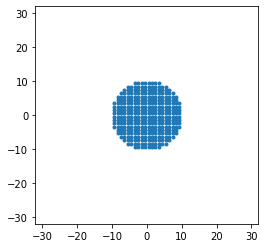

In [8]:
import matplotlib.pyplot as plt

# Visualising the stimulus 
stim_index = set_stimulus(lattice,[0,0],1)
lattice_stimulus = lattice[j_indices]
print(stim_index)

fig,ax = plt.subplots(figsize=(4,4))
plt.plot(lattice_stimulus[:,0],lattice_stimulus[:,1],'.')
ax.set_xlim((-32,32))
ax.set_ylim((-32,32))
plt.show()


In [12]:
import numpy as np
x = np.array([1,2,3,4,5])
np.argwhere(x>3)

r = (lattice[:,0]**2+lattice[:,1]**2)**0.5
r < 3
np.argwhere(r<3)
syn_poisson.connect(i=source_index, j=np.argwhere(r<3))

NameError: name 'syn_poisson' is not defined

In [69]:
def set_stimulus(lattice,centre,radius): # Find the set of lattice indices for a circular stimulus
    x = lattice[:,0]
    y = lattice[:,1]
    r = ((x-centre[0])**2 + (y-centre[1])**2)**0.5
    stim_index_base = np.argwhere(r<=radius)
    stim_index = [int(i) for i in stim_index_base]
    return stim_index



width = 64 

centre1 = [-15,15]
centre2 = [15,-15]
radius = 5
lattice = coordination.makelattice(width,width-1,[0,0])
stim_index = set_stimulus(lattice,centre1,radius) + set_stimulus(lattice,centre2,radius)
print(len(stim_index))
stim_index = stim_index + stim_index
len(stim_index)

166


332

In [ ]:
n=63
n**2 total neurons
set up poissongroup with n**2 elements
the connect I=[0,1,2,...,n**2-1] to j=[0,1,2,...,n**2-1]
time-dependent weights
model=model_neu_syn_NMDA.synapse_e_AD,
                            on_pre='''x_E_post += w''')
on_pre='''x_E_post += w * sin(simulation_time)''')


In [3]:
j_indices = np.array([1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1498, 1499, 1500,
       1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1561, 1562,
       1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573,
       1574, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633,
       1634, 1635, 1636, 1637, 1638, 1639, 1687, 1688, 1689, 1690, 1691,
       1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702,
       1703, 1704, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759,
       1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1814, 1815,
       1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826,
       1827, 1828, 1829, 1830, 1831, 1832, 1833, 1878, 1879, 1880, 1881,
       1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892,
       1893, 1894, 1895, 1896, 1897, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2134,
       2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145,
       2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2198, 2199, 2200,
       2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211,
       2212, 2213, 2214, 2215, 2216, 2217, 2262, 2263, 2264, 2265, 2266,
       2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277,
       2278, 2279, 2280, 2281, 2327, 2328, 2329, 2330, 2331, 2332, 2333,
       2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344,
       2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401,
       2402, 2403, 2404, 2405, 2406, 2407, 2408, 2456, 2457, 2458, 2459,
       2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470,
       2471, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530,
       2531, 2532, 2533, 2534, 2586, 2587, 2588, 2589, 2590, 2591, 2592,
       2593, 2594, 2595, 2596, 2597, 2652, 2653, 2654, 2655, 2656, 2657,
       2658, 2659])


## Experimentation: moving stimulus

In [ ]:
posi_stim_e1 = NeuronGroup(ijwd1.Ne,  
                '''rates =  bkg_rates + stim_1 + stim_2 : Hz
                bkg_rates : Hz
                stim_1 : Hz
                stim_2 : Hz
                ''', threshold='rand()<rates*dt')

posi_stim_e1 = NeuronGroup(ijwd1.Ne,  
                '''rates =  bkg_rates + stim*cos(t) : Hz
                bkg_rates : Hz
                stim : Hz
                ''', threshold='rand()<rates*dt')

[44.54772721 43.84632254 43.15669125 ... 43.15669125 43.84632254
 44.54772721]


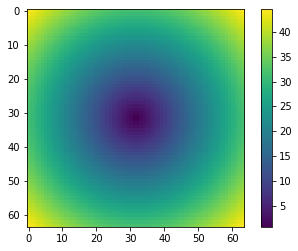

In [55]:
# Redefine input rates function to depend on velocity/time

import brian2.numpy_ as np

from connection import coordination

def input_spkrate_mov(maxrate, sig, position, n_side=64, width=64):
    lattice = coordination.makelattice(width, n_side, [0,0])
    n_stim = len(position)
    for i in range(n_stim):
        dist_sti = coordination.lattice_dist(lattice, width, position[i])
        print(dist_sti)
        if i == 0:
            rate_sti = np.zeros(len(dist_sti))
        rate_sti += maxrate[i]*np.exp((-0.5)*(dist_sti/sig[i])**2)

    return dist_sti

t = 7.5 #current time
vel = 2 #units/timestep
start_x = -15
rate = input_spkrate_mov(maxrate=[800], sig = [6], position = [[start_x+vel*t,0]])
rate = rate.reshape(64,64)
plt.figure()
plt.imshow(rate)
plt.colorbar()
plt.show()



In [11]:
tau = 20*metre
print(tau/metre)
tau -= 10*metre
tau

20.0


10. * metre

In [ ]:
pos_dict = {'pos':-20}
@network_operation(dt = 25*ms)
def change_pos():
    # syn_extnl_e1.w += 10*nS
    # print(syn_extnl_e1.w)
    pos_dict['pos'] += 1
    posi_stim_e1.stim_1 += poisson_stimuli.input_spkrate(maxrate = [500], sig=[6], position=[[20,0]])*Hz
    # syn_extnl_e1 = Synapses(posi_stim_e1, group_e_1, model=synapse_model_e, on_pre='x_E_extnl_post += w')
    # syn_extnl_e1.connect('i==j')
    # syn_extnl_e1.w = ijwd1.w_extnl*nS#*tau_s_de_*nS
    print(posi_stim_e1.stim_1)
